## Importacion de librerías

In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import cv2
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm

c:\Users\sergi\PYTHON files\MIOTI\02-99 TFM Deep Learning\.venv_TFM_DL\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# 📂 Rutas
INPUT_FOLDER = "./outfits_procesados_512_rgb/"
OUTPUT_FOLDER = "./outfits_procesados_256x512_rgb/"

# Crear carpeta de salida si no existe
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# 📑 Lista de imágenes originales
image_files = [f for f in os.listdir(INPUT_FOLDER) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"🔍 Encontradas {len(image_files)} imágenes en '{INPUT_FOLDER}'")

🔍 Encontradas 1485 imágenes en './outfits_procesados_512_rgb/'


## Código para una sola imagen

Forma de la imagen cargada (BGRA): (512, 512, 3)


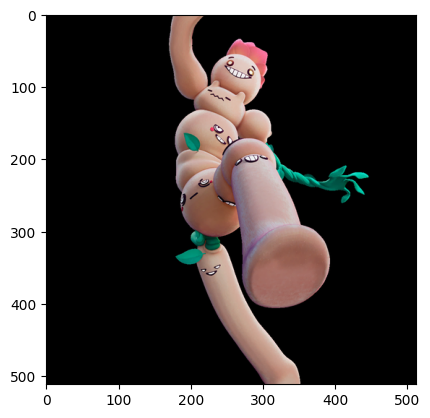

In [13]:
# --- Código para preprocesar la imagen limpiando los fondos ---
input_path = os.path.join(INPUT_FOLDER, image_files[250])

# 1. Cargar la imagen manteniendo todos los canales (incluido el alfa)
image_bgr = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)

if image_bgr is None:
    print(f"Error: No se pudo cargar la imagen en {input_path}")
else:
    print(f"Forma de la imagen cargada (BGRA): {image_bgr.shape}")
    
    # Convertir la imagen a RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    # Ver la imagen original
    plt.imshow(image_rgb)
    plt.show()


In [4]:
image_rgb[100, 250]

array([168, 171, 177], dtype=uint8)

In [5]:
# --- Función is_grounded ---
def is_grounded(image, num_rows_to_check=5):
    """
    Verifica si una imagen está "pegada al suelo" comprobando si las últimas N filas
    son predominantemente negras.

    Args:
        image (np.array): La imagen en formato RGB.
        num_rows_to_check (int): Número de filas inferiores a verificar.

    Returns:
        bool: True si el personaje parece estar tocando el "suelo" (no hay mucho negro abajo),
            False en caso contrario.
    """

    height = image.shape[0]

    # Seleccionar las últimas `num_rows_to_check` filas
    bottom_rows = image[height - num_rows_to_check:height, :, :]

    # Contar píxeles negros (0,0,0) en estas filas
    # Un píxel es negro si todos sus canales son 0
    black_pixels_mask = np.all(bottom_rows == [0, 0, 0], axis=-1)
    num_black_pixels = np.sum(black_pixels_mask)

    total_pixels_in_bottom_rows = bottom_rows.shape[0] * bottom_rows.shape[1]

    # Lógica: Si la proporción de píxeles NO negros en la parte inferior es significativa,
    # entonces el personaje está "grounded".
    # Por lo tanto, si la proporción de píxeles NEGROS es BAJA, está grounded.
    proportion_black = num_black_pixels / total_pixels_in_bottom_rows
    
    # Si MENOS del X% de los píxeles inferiores son negros, asumimos que el personaje está ahí.
    # Ejemplo: si menos del 70% de los píxeles inferiores son negros, está "grounded".
    # Ajusta este `grounded_threshold_black_proportion` según tus necesidades.
    # Si casi todo es negro (e.g., >98% negro), entonces NO está grounded.
    if proportion_black > 0.98:
        return False # No hay personaje en la parte inferior
    else:
        return True # Hay personaje en la parte inferior

In [6]:
# --- Función is_ceiled ---
def is_ceiled(image, num_rows_to_check=5):
    """
    Verifica si un personaje en una imagen está "pegado al techo" comprobando
    si las primeras N filas son predominantemente negras.

    Args:
        image (np.array): La imagen en formato RGB.
        num_rows_to_check (int): Número de filas superiores a verificar.

    Returns:
        bool: True si el personaje parece estar tocando el "techo" (no hay mucho negro arriba),
            False en caso contrario.
    """

    height = image.shape[0]

    # Seleccionar las primeras `num_rows_to_check` filas
    top_rows = image[0:num_rows_to_check, :, :]

    # Contar píxeles negros (0,0,0) en estas filas
    # Un píxel es negro si todos sus canales son 0
    black_pixels_mask = np.all(top_rows == [0, 0, 0], axis=-1)
    num_black_pixels = np.sum(black_pixels_mask)

    total_pixels_in_top_rows = top_rows.shape[0] * top_rows.shape[1]

    proportion_black = num_black_pixels / total_pixels_in_top_rows
    
    # Lógica: Si la proporción de píxeles negros en la parte SUPERIOR es BAJA,
    # entonces el personaje está "ceiled" (pegado al techo).
    if proportion_black > 0.98:
        return False # No hay personaje en la parte superior
    else:
        return True # Hay personaje en la parte superior

In [7]:
def detect_margins(image_bgr):
    """
    Detecta los márgenes laterales visibles en una imagen BGR, es decir, las columnas
    desde la primera hasta la última que contienen información visual (valores distintos de cero).

    Esta función es útil para centrar y recortar imágenes eliminando márgenes vacíos o negros.

    Parámetros:
    ----------
    image_bgr : np.ndarray
        Imagen en formato BGR (altura, ancho, 3 canales) como array de NumPy.

    Retorna:
    -------
    tuple[int, int]
        Una tupla (column_left, column_right) que indica el índice de la primera y última columna
        con contenido visible. Si no se detecta contenido, devuelve (0, image_bgr.shape[1]).
    """
    height, width, _ = image_bgr.shape
    column_left, column_right = 0, width

    # Convertir imagen a escala de grises para simplificar el cálculo
    gray = np.sum(image_bgr, axis=2)

    # Buscar primer y último índice de columna con valores > 0
    non_zero_columns = np.where(np.any(gray > 0, axis=0))[0]

    if non_zero_columns.size > 0:
        column_left = non_zero_columns[0]
        column_right = non_zero_columns[-1] + 1  # +1 para slicing inclusivo
    else:
        # No se detectó contenido; se devuelven márgenes por defecto
        column_left, column_right = 0, width

    return column_left, column_right



In [8]:
from PIL import Image
import numpy as np
import cv2

def resize_visible_area_with_pil(image_bgr, column_left, column_right, target_width=256, target_height=512):
    """
    Recorta la imagen entre márgenes visibles, reduce el ancho a target_width usando PIL (LANCZOS),
    y añade padding por arriba si la altura resultante es menor que target_height.

    Args:
        image_bgr (np.ndarray): Imagen original en formato BGR.
        column_left (int): Índice de la primera columna visible.
        column_right (int): Índice de la última columna visible.
        target_width (int): Ancho final deseado (por defecto: 256).
        target_height (int): Altura final deseada (por defecto: 512).

    Returns:
        np.ndarray: Imagen ajustada y con padding por arriba si es necesario.
    """
    # --- Recortar contenido útil ---
    image_cropped = image_bgr[:, column_left:column_right]

    # --- Convertir a PIL RGB ---
    image_rgb = cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)

    # --- Escalado proporcional al nuevo ancho ---
    original_width, original_height = pil_image.size
    new_height = int(original_height * (target_width / original_width))

    pil_resized = pil_image.resize((target_width, new_height), Image.Resampling.LANCZOS)

    # --- Convertir de nuevo a BGR ---
    image_bgr_resized = cv2.cvtColor(np.array(pil_resized), cv2.COLOR_RGB2BGR)

    # --- Padding por arriba si la altura es menor a target_height ---
    if new_height < target_height:
        pad_top = target_height - new_height
        image_bgr_resized = cv2.copyMakeBorder(
            image_bgr_resized,
            top=pad_top, bottom=0,
            left=0, right=0,
            borderType=cv2.BORDER_CONSTANT,
            value=(0, 0, 0)
        )

    # --- Recorte de seguridad por si hay exceso ---
    return image_bgr_resized[:target_height, :target_width]


In [9]:
# --- Función de Redimensionamiento ---
def crop_image_256x512(
    image_file,
    image_bgr,
    OUTPUT_FOLDER,
    debug=False
):
    """
    Ajusta una imagen a un tamaño fijo de 256x512 píxeles, centrando el contenido útil
    horizontalmente y aplicando zoom out o padding lateral si es necesario. 
    El padding vertical se añade por arriba si la imagen es más corta que 512px.

    Parámetros:
    ----------
    image_file : str
        Ruta del archivo de imagen original (utilizado para nombrar el archivo de salida).
    
    image_bgr : numpy.ndarray
        Imagen en formato BGR (tal como la carga OpenCV).
    
    OUTPUT_FOLDER : str
        Carpeta donde se almacenará la imagen resultante.
    
    debug : bool, opcional
        Si es True, imprime mensajes de depuración útiles durante el procesamiento.

    Retorna:
    -------
    None
        Guarda la imagen ajustada en OUTPUT_FOLDER.
    """
    
    # --- Detectar márgenes útiles ---
    column_left, column_right = detect_margins(image_bgr)
    width_visible = column_right - column_left
    if debug:
        print(f"[INFO] Márgenes detectados: {column_left} - {column_right} (ancho visible: {width_visible})")

    # --- Ajustar imagen ---
    if width_visible > 256:
        # Zoom out proporcional con padding superior si es necesario
        if debug:
            print(f"[INFO] Redimensionando contenido visible a 256px de ancho con PIL")

        image_cropped_bgr = resize_visible_area_with_pil(
            image_bgr,
            column_left,
            column_right,
            target_width=256,
            target_height=512
        )

    else:
        # Añadir márgenes laterales para centrar si la imagen es más estrecha
        margin = (256 - width_visible) // 2
        if debug:
            print(f"[INFO] Añadiendo padding lateral: {margin}px por cada lado")

        image_cropped_bgr = image_bgr[:, column_left:column_right]
        image_cropped_bgr = cv2.copyMakeBorder(
            image_cropped_bgr,
            top=0, bottom=0,
            left=margin, right=256 - width_visible - margin,
            borderType=cv2.BORDER_CONSTANT,
            value=(0, 0, 0)
        )

        # Añadir padding por arriba si la altura es menor a 512
        height = image_cropped_bgr.shape[0]
        if height < 512:
            pad_top = 512 - height
            if debug:
                print(f"[INFO] Añadiendo padding superior: {pad_top}px")
            image_cropped_bgr = cv2.copyMakeBorder(
                image_cropped_bgr,
                top=pad_top, bottom=0,
                left=0, right=0,
                borderType=cv2.BORDER_CONSTANT,
                value=(0, 0, 0)
            )

        # Recorte de seguridad
        image_cropped_bgr = image_cropped_bgr[:512, :256]
    
    # --- Guardar imagen final ---
    base_name = os.path.splitext(os.path.basename(image_file))[0]
    output_path = os.path.join(OUTPUT_FOLDER, f"{base_name}_256x512.png")
    cv2.imwrite(output_path, image_cropped_bgr)

    if debug:
        print(f"[✅] Imagen guardada en: {output_path}")


In [16]:
# --- Código para cortar una imagen 512x512 a 256x512 ---
input_path = os.path.join(INPUT_FOLDER, image_files[269])

# 1. Cargar la imagen manteniendo todos los canales (incluido el alfa)
image_bgr = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)

crop_image_256x512(
    image_files[269],
    image_bgr,
    OUTPUT_FOLDER,
    debug=True
)

[INFO] Márgenes detectados: 120 - 405 (ancho visible: 285)
⚠️ La imagen 'Character_OmegaAngel_512_3c.png' original está ceiled
[INFO] Redimensionando contenido visible a 256px de ancho con PIL
[✅] Imagen guardada en: ./outfits_procesados_256x512_rgb/Character_OmegaAngel_512_3c_256x512.png


## Código para todas las imágenes del dataset

In [17]:
for img_file in tqdm(image_files, desc="Redimensionando skins a 256x512"):
    # Cargar la imagen original
    img_path = os.path.join(INPUT_FOLDER, img_file)
    image_bgr = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

    # Verificar si la imagen se cargó correctamente
    if image_bgr is None:
        print(f"Error: No se pudo cargar la imagen en {img_path}")
        continue

    # Redimensionar imágenes
    crop_image_256x512(
        img_file,
        image_bgr,
        OUTPUT_FOLDER
    )

Redimensionando skins a 256x512: 100%|██████████| 1485/1485 [00:21<00:00, 68.94it/s]
